#Pneumonia (viral and bacterial) detection using chest x-ray images 

### Downlading data using kaggle 

In [3]:
pip install kaggle 

In [4]:
from google.colab import files

files.upload() # Upload kaggle.json from kaggle --> account --> create new API token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielcohennn","key":"dcfc2d57047166fa1599dd60fc91f270"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia # Downloading dataset from kaggle

100% 2.29G/2.29G [00:30<00:00, 21.9MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.7MB/s]


In [8]:
!pip install zip_files # For unzipping files 

In [9]:
from zipfile import ZipFile

filename = "chest-xray-pneumonia.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('done')

done


### Loading libraries and data

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os


In [11]:
main_dir = "/content/chest_xray/chest_xray"

train_dir = os.path.join(main_dir, 'train')

test_dir = os.path.join(main_dir, 'test')

train_p_dir = os.path.join(train_dir, 'PNEUMONIA')

train_n_dir = os.path.join(train_dir, 'NORMAL')

test_p_dir = os.path.join(test_dir, 'PNEUMONIA')

test_n_dir = os.path.join(test_dir, 'NORMAL')

train_p_names = os.listdir(train_p_dir)
train_n_names = os.listdir(train_n_dir)
test_p_names = os.listdir(test_p_dir)
test_n_names = os.listdir(test_n_dir)

print("Total images in the training set: ", len(train_p_names+train_n_names))
print("Total images in the test set: ", len(test_p_names+test_n_names))

Total images in the training set:  5218
Total images in the test set:  624


### Visualization and preprocessing 

<function matplotlib.pyplot.show>

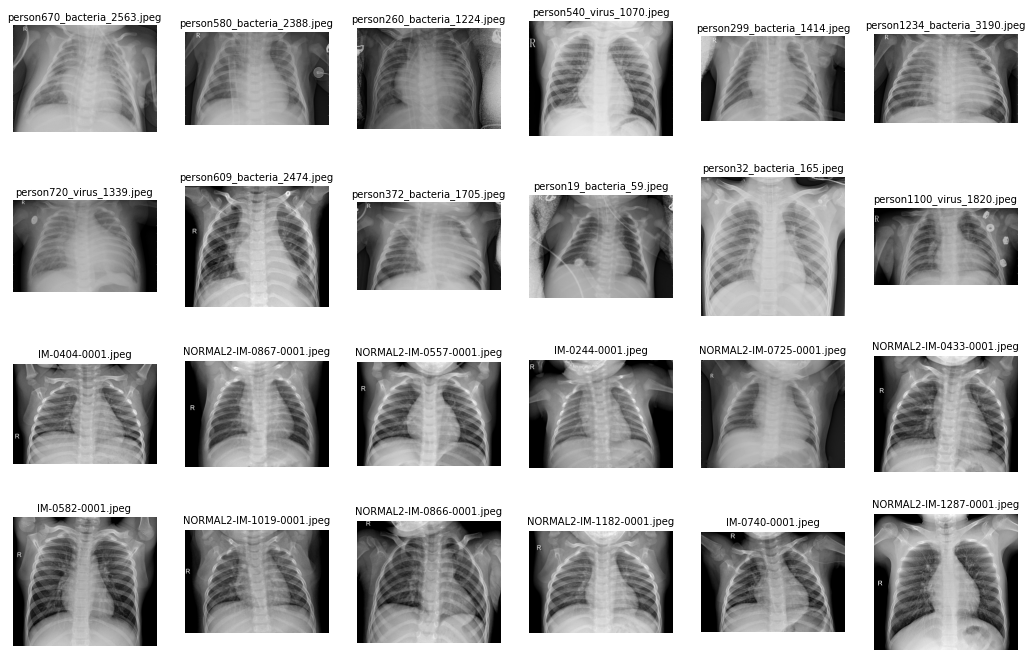

In [12]:
import matplotlib.image as mpimg

r = 6
c = 6

fig = plt.gcf()
fig.set_size_inches(18,18)

p_xray_pictures = [os.path.join(train_p_dir, filename) for filename in train_p_names[0:12]]
n_xray_pictures = [os.path.join(train_n_dir, filename) for filename in train_n_names[0:12]]

lst = p_xray_pictures + n_xray_pictures
for i, img_path in enumerate(lst):
    data = img_path.split('/', 6)[6]
    x = plt.subplot(r, c, i+1)
    x.axis('off')
    img = mpimg.imread(img_path)
    x.set_title(data, fontsize=10)
    plt.imshow(img, cmap='gray')

plt.show

In [13]:
# generate training, testing and validation batches 

data_generate_train = ImageDataGenerator(rescale=1/255, validation_split=0.2, zoom_range=0.2,
                                         horizontal_flip=True)
data_generate_validation = ImageDataGenerator(rescale=1/255)
data_generate_test = ImageDataGenerator(rescale=1/255)

train_gen = data_generate_train.flow_from_directory(train_dir, target_size=(150,150),
                                                          subset='training', batch_size=32,
                                                          class_mode='binary')
validation_gen = data_generate_train.flow_from_directory(train_dir, target_size=(150,150),
                                                          subset='validation', batch_size=32,
                                                          class_mode='binary')
test_gen = data_generate_test.flow_from_directory(test_dir, target_size=(150,150),
                                                          batch_size=32, class_mode='binary')

# class indices
print(train_gen.class_indices)

#image shape
print(train_gen.image_shape)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
(150, 150, 3)


### Building, training and predicting model

In [70]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 15, 256)      

In [71]:
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

trained_model = model.fit(train_gen, epochs=30, validation_data=validation_gen)

Epoch 1/30
131/131 [==============================] - 71s 534ms/step - loss: 0.5812 - accuracy: 0.7367 - val_loss: 0.5776 - val_accuracy: 0.7430
Epoch 2/30
131/131 [==============================] - 69s 527ms/step - loss: 0.5157 - accuracy: 0.7617 - val_loss: 0.3421 - val_accuracy: 0.8562
Epoch 3/30
131/131 [==============================] - 69s 527ms/step - loss: 0.2920 - accuracy: 0.8729 - val_loss: 0.3141 - val_accuracy: 0.8600
Epoch 4/30
131/131 [==============================] - 69s 524ms/step - loss: 0.2365 - accuracy: 0.9012 - val_loss: 0.2280 - val_accuracy: 0.8936
Epoch 5/30
131/131 [==============================] - 68s 522ms/step - loss: 0.2109 - accuracy: 0.9180 - val_loss: 0.2233 - val_accuracy: 0.9012
Epoch 6/30
131/131 [==============================] - 68s 521ms/step - loss: 0.1958 - accuracy: 0.9214 - val_loss: 0.2013 - val_accuracy: 0.9147
Epoch 7/30
131/131 [==============================] - 68s 520ms/step - loss: 0.2051 - accuracy: 0.9165 - val_loss: 0.3388 - val_ac

Text(0.5, 0, 'Epochs')

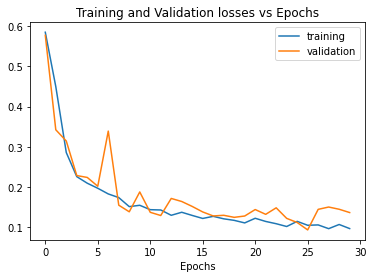

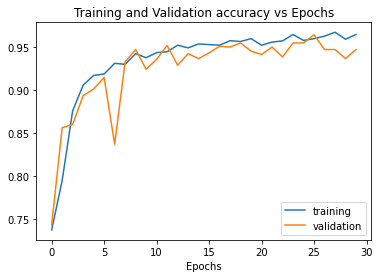

In [72]:
# get keys of trained model
trained_model.history.keys

# plot training and validation loss vs epochs
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs')
plt.xlabel('Epochs')

plt.figure()

# plot training and validation accuracy vs epochs
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs')
plt.xlabel('Epochs')

In [73]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy*100}%, Test loss: {test_loss*100}%")

20/20 [==============================] - 5s 273ms/step - loss: 0.2363 - accuracy: 0.9247
Test accuracy: 92.46794581413269%, Test loss: 23.626860976219177%


['/content/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg', '/content/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg', '/content/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg', '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg', '/content/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg', '/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg']


<function matplotlib.pyplot.show>

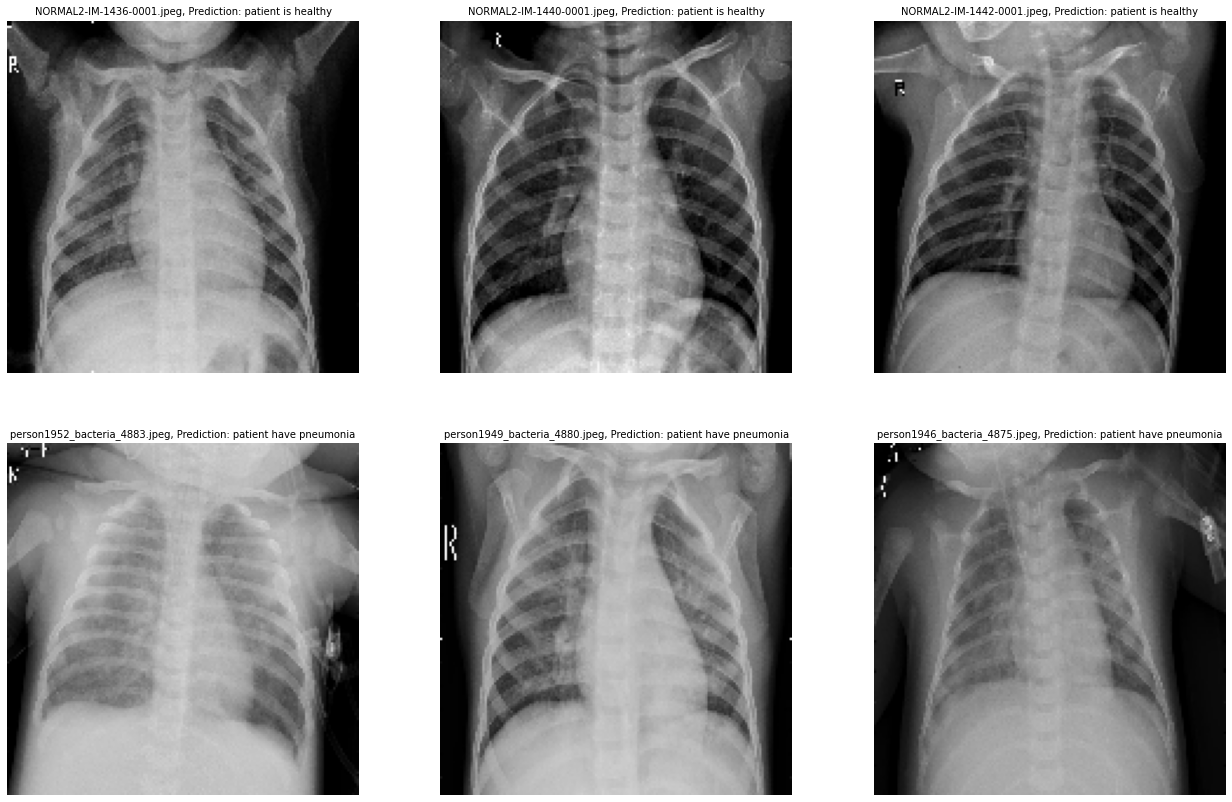

In [82]:
# predicting on new data
from tensorflow.keras.preprocessing import image

new_pred_dir = '/content/chest_xray'
new_pred_normal = os.path.join(new_pred_dir, 'val/NORMAL')
new_pred_pneumonia = os.path.join(new_pred_dir, 'val/PNEUMONIA')
normal_names = os.listdir(new_pred_normal)
pneumonia_names = os.listdir(new_pred_pneumonia)

normal_pics = [os.path.join(new_pred_normal, filename) for filename in normal_names[3:6]]
pneumonia_pics = [os.path.join(new_pred_pneumonia, filename) for filename in pneumonia_names[3:6]]

merged = normal_pics + pneumonia_pics

r = 3
c = 3

fig = plt.gcf()
fig.set_size_inches(22,22)

for i, filename in enumerate(merged):

  img = image.load_img(filename, target_size=(150,150))
  
  images = image.img_to_array(img)
  images = np.expand_dims(images, axis=0)
  prediction = model.predict(images)
  if prediction == 0:
    pred = 'Prediction: patient is healthy'
  else:
    pred = 'Prediction: patient have pneumonia'
  x = plt.subplot(r, c, i+1)
  x.axis('off')
  x.set_title(filename.split('/')[5] + ', ' + pred, fontsize=10)
  plt.imshow(img, cmap='gray')

plt.show